# Setup

In [2]:
import io
import base64
import sys
%matplotlib inline
# %matplotlib notebook
import plotly as plty
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
# import h5py
import scipy as sp
import pandas as pd
# import sklearn as sk 

%reload_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

# FEM 1D: $\frac{d^2u}{dx^2} = -f(x)$

In [22]:
# grid
n = 100
x = np.linspace(0, 1, n)
dx = x[1:] - x[:-1]

In [23]:
# field u
u = np.zeros_like(x)
u[0] = 2
u[-1] = 1

In [24]:
# rhs b
b = np.zeros_like(x[1:-1])
b[0] = (u[0]/dx[0])
b[1:-1] = 0
b[-1] = (u[-1]/dx[n-2])

# soource f
b[45:55] = 0

In [25]:
# A matrix
A = np.zeros((n-2, n-2))

# i=1
A[0, 0] = (1/dx[0]) + (1/dx[1])
A[0, 1] = - (1/dx[1])

# i=2...n-3
for i in range(2, n-2):
    A[i-1, i-2] = - (1/dx[i-1])
    A[i-1, i-1] = (1/dx[i-1]) + (1/dx[i])
    A[i-1, i]   = - (1/dx[i])

# i=n-2
A[-1, -2] = - (1/dx[n-3])
A[-1, -1] = (1/dx[n-3]) + (1/dx[n-2])

In [26]:
# solution
u[1:-1] = sp.linalg.solve(A, b)

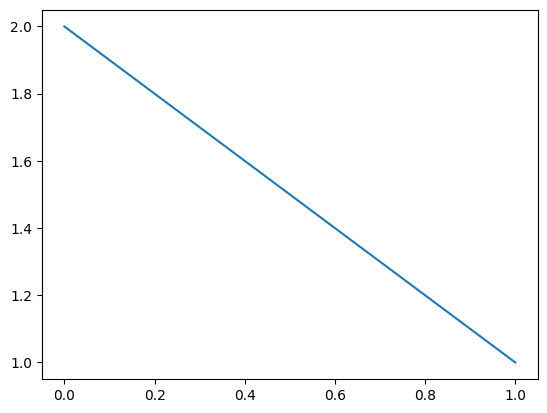

In [27]:
# plot
plt.plot(x, u)
# plt.ylim([-0.01, 1.01])
plt.show()

In [114]:
# test
# np.abs(np.dot(A, u[1:-1]) - b) < 1e-13

# Delaunay

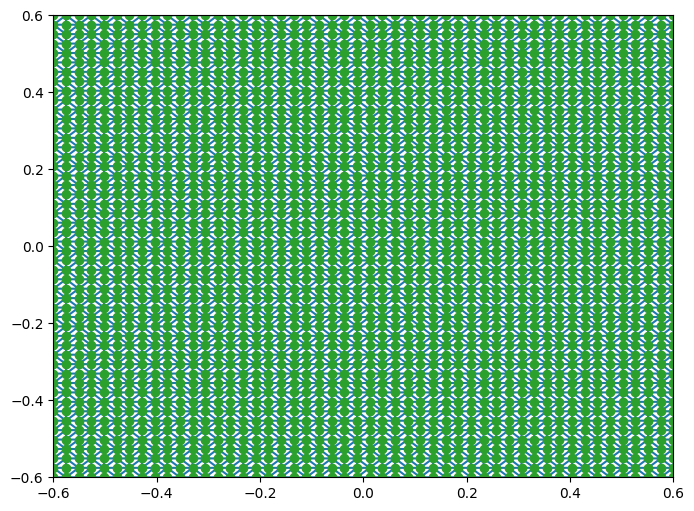

In [54]:
# points
x_min, x_max, n_x = -0.6, 0.6, 50
y_min, y_max, n_y = -0.6, 0.6, 50
r = 0.5

points = []
nodes_x = np.linspace(x_min, x_max, n_x)
nodes_y = np.linspace(y_min, y_max, n_y)
for x in nodes_x:
    for y in nodes_y:
        points.append([x, y])
        
points = np.array(points)

# triangle
tri = sp.spatial.Delaunay(points)
boundary_points = np.unique(tri.convex_hull.flatten())
# print(boundary_points)
# print(np.sqrt((tri.points[boundary_points]**2).sum(axis=1))/r)

# plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

(225,)


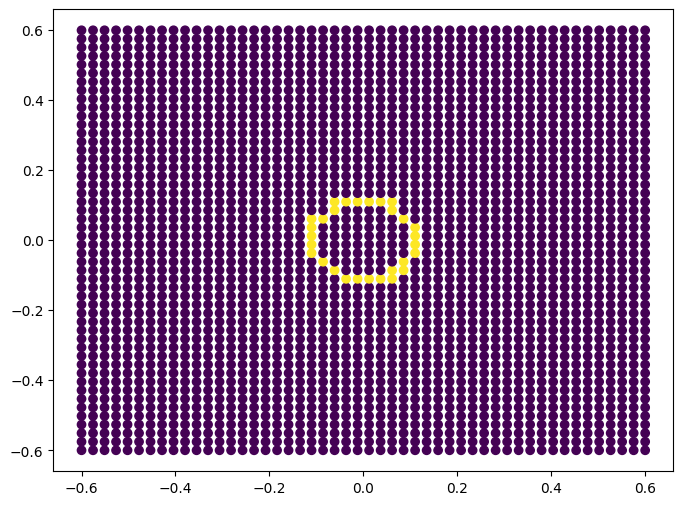

In [55]:
r2 = 0.1**2

pflg = np.ones(tri.npoints, dtype=bool)
for idx, p in enumerate(tri.points):
    if (p**2).sum() < r2:
        pflg[idx] = False

# print(pflg)

sflg = np.ones(tri.nsimplex, dtype=bool)
for idx, p_idx in enumerate(tri.simplices):
    if not pflg[p_idx[0]] or not pflg[p_idx[1]] or not pflg[p_idx[2]]:
        sflg[idx] = False

# print(sflg)

bflg = np.zeros(tri.npoints, dtype=bool)
counter = 0
for idx, p_idx in enumerate(tri.simplices):
    if not sflg[idx]:
        p1, p2, p3 = (tri.points[p_idx[0]], tri.points[p_idx[1]], tri.points[p_idx[2]])
        if (p1**2).sum() >= r2:
            bflg[p_idx[0]] = True
            boundary_points = np.append(boundary_points, p_idx[0]*np.ones(1, dtype=int))
        if (p2**2).sum() >= r2:
            bflg[p_idx[1]] = True
            boundary_points = np.append(boundary_points, p_idx[1]*np.ones(1, dtype=int))
        if (p3**2).sum() >= r2:
            bflg[p_idx[2]] = True
            boundary_points = np.append(boundary_points, p_idx[2]*np.ones(1, dtype=int))

boundary_points = np.unique(boundary_points)

plt.scatter(x=points[:, 0], y=points[:, 1], c=bflg)
plt.show()

In [ ]:
for ch_idx, edge_points in enumerate(tri.convex_hull):
    p1_idx, p2_idx = edge_points
    p1, p2 = tri.points[edge_points]
    print(ch_idx, edge_points, p1, p2)

# FEM 2D: $\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = -f(x, y)$

The mesh has 78 boundary nodes, and 322 internal nodes


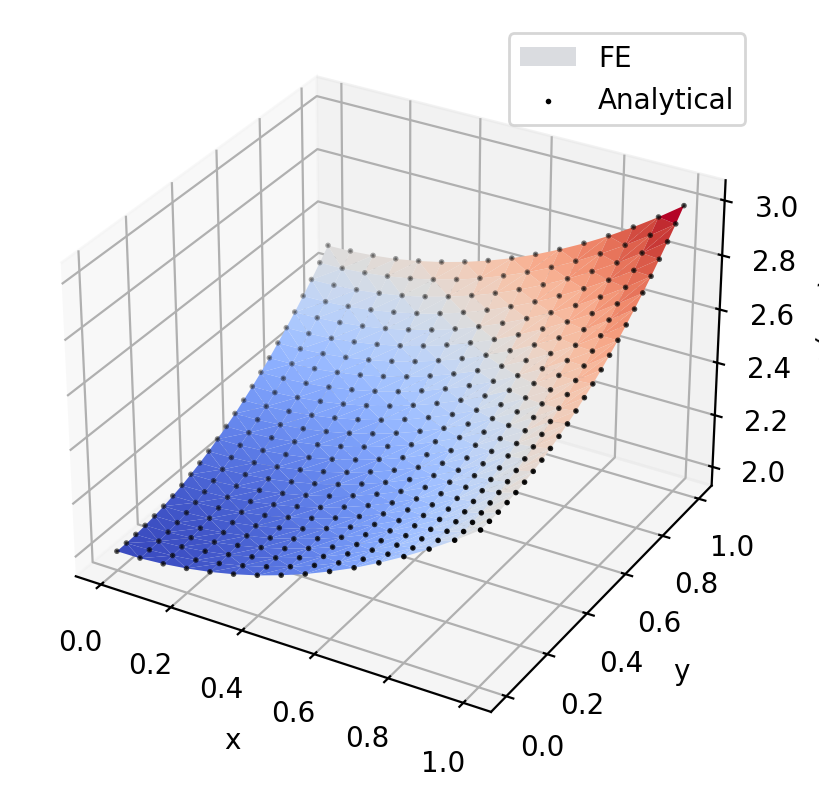

In [82]:
# FEM solution
from FEM_poisson2d import Mesh, FEPoisson2D

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        return -2

    # Domain space
    x_min, x_max, n_x = 0, 1, 16
    y_min, y_max, y_n = 0, 1, 25

    """ 
    Create rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, y_n)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 2
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        if p[0] == 0 and p[1] == 0:
            mesh.bc_points["dirichlet"][point_index] = u00

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == 0 and p2[0] == 0:  # x = 0, West
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[0] == 1 and p2[0] == 1:  # x = 1, East
            mesh.bc_points["neumann_edge"][ch_idx] = [1, 1]
        elif p1[1] == 0 and p2[1] == 0:  # y = 0, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == 1 and p2[1] == 1:  # y = 1, North
            mesh.bc_points["neumann_edge"][ch_idx] = [1, 1]

    """ 
    Solve the 2D Poisson problem 
    """
    # Set a simulation object
    poisson = FEPoisson2D(mesh, RHS)
    # Process - build A and b
    poisson.process()
    # Solve for u = A^-1 b
    poisson.solve()
    # Get the result
    u = poisson.u

    """ 
    Plot FE and analytical solution 
    """
    # Analytical solution
    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    u_exact = 0.5 * (x ** 2 + y ** 2) + u00
    # u_exact = np.sin(x) * np.sin(y) + u00

    # print(np.abs(u_exact - u.flatten()) < 1e-3)

    ax = plt.figure(dpi=200).add_subplot(projection='3d')
    ax.plot_trisurf(
        mesh.tri.points[:, 0], mesh.tri.points[:, 1], u.flatten(),
        linewidth=0.2, antialiased=True, cmap=cm.coolwarm, label="FE")
    ax.scatter(x, y, u_exact, marker='o', c='black', s=1, label="Analytical")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'$u(x,y)$')
    ax.legend()
    plt.show()

The mesh has 36 boundary nodes, and 64 internal nodes
[0.         0.00508214 0.00728213 0.0086916  0.00925326 0.00989112
 0.01037649 0.01097877 0.01108888 0.01137437 0.00507306 0.00621701
 0.00767731 0.00823379 0.00858925 0.00996719 0.00959292 0.00956776
 0.01100096 0.00989644 0.00724578 0.00764787 0.00778852 0.00823285
 0.0086619  0.00913513 0.00833036 0.01001215 0.01003071 0.00973587
 0.00861418 0.0081524  0.00815808 0.00814805 0.00978931 0.00835226
 0.00844364 0.00983715 0.00779413 0.01069528 0.00914269 0.0084453
 0.0084442  0.00967538 0.00756738 0.00904857 0.00864402 0.00759127
 0.01061306 0.00745737 0.00981416 0.00980106 0.00859699 0.00811427
 0.01014699 0.00655368 0.01074824 0.00703007 0.00694952 0.01096174
 0.01051148 0.00968745 0.01031478 0.00830091 0.00850492 0.00818809
 0.00749743 0.01051454 0.00647942 0.00717023 0.0114066  0.01037441
 0.00875003 0.01029248 0.00690291 0.01097405 0.00823144 0.0047759
 0.01031742 0.00401238 0.01105194 0.01004705 0.01054525 0.00781951
 0.0101066

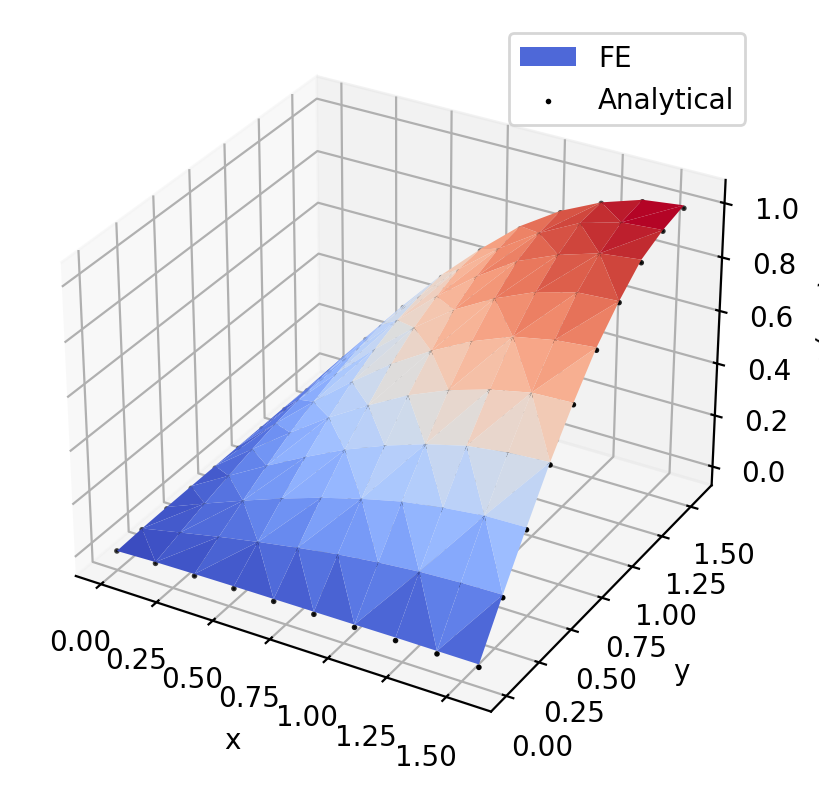

In [81]:
# FEM solution
from FEM_poisson2d import Mesh, FEPoisson2D

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        return 2 * np.sin(_x) * np.sin(_y) 

    # Domain space
    x_min, x_max, n_x = 0, np.pi/2, 10
    y_min, y_max, y_n = 0, np.pi/2, 10

    """ 
    Create a rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, y_n)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 0
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        if p[0] == 0 and p[1] == 0:
            mesh.bc_points["dirichlet"][point_index] = u00

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == 0 and p2[0] == 0:  # x = 0, West
            mesh.bc_points["neumann_edge"][ch_idx] = [-np.sin(p1[1]), -np.sin(p2[1])]
        elif p1[0] == np.pi/2 and p2[0] == np.pi/2:  # x = 1, East
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == 0 and p2[1] == 0:  # y = 0, South
            mesh.bc_points["neumann_edge"][ch_idx] = [-np.sin(p1[0]), -np.sin(p2[0])]
        elif p1[1] == np.pi/2 and p2[1] == np.pi/2:  # y = 1, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D Poisson problem 
    """
    # Set a simulation object
    poisson = FEPoisson2D(mesh, RHS)
    # Process - build A and b
    poisson.process()
    # Solve for u = A^-1 b
    poisson.solve()
    # Get the result
    u = poisson.u
    # A = poisson.A
    # b = poisson.b
    # print(A.shape, b.shape)

    """ 
    Plot FE and analytical solution 
    """
    # Analytical solution
    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    u_exact = np.sin(x) * np.sin(y) + u00

    print(np.abs(u_exact - u.flatten()))

    ax = plt.figure(dpi=200).add_subplot(projection='3d')
    ax.plot_trisurf(
        mesh.tri.points[:, 0], mesh.tri.points[:, 1], u.flatten(),
        linewidth=0.2, antialiased=True, cmap=cm.coolwarm, label="FE")
    ax.scatter(x, y, u_exact, marker='o', c='black', s=1, label="Analytical")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'$u(x,y)$')
    ax.legend()
    plt.show()

# FEM 2D: $\frac{\partial u}{\partial t} = \frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} + f(x, y)$

## FEM solution fixed temperature at two sides

In [335]:
# FEM solution fixed temperature at two sides
from FEM_heat2d import Mesh, FEheat2D

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        return 0.0

    # Domain space
    iteration_max = 100
    x_min, x_max, n_x = -0.5, 0.5, 10
    y_min, y_max, n_y = -0.5, 0.5, 10

    """ 
    Create a rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 1.0
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        if p[0] == x_min:  # x = x_min, West
            mesh.bc_points["dirichlet"][point_index] = 0.0
        if p[0] == x_max:  # x = x_max, East
            mesh.bc_points["dirichlet"][point_index] = 1.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        # if p1[0] == x_min and p2[0] == x_min:  # x = x_min, West
            # mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        # if p1[0] == x_max and p2[0] == x_max:  # x = x_max, East
            # mesh.bc_points["neumann_edge"][ch_idx] = [0.0, 0.0]
        if p1[1] == y_min and p2[1] == y_min:  # y = y_min, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == y_max and p2[1] == y_max:  # y = y_max, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem 
    """
    # Set a simulation object
    heat = FEheat2D(mesh, RHS)
    # Process - build A and b
    heat.initialze()
    # Solve for u = A^-1 b

    print('iteration=')
    for i in range(iteration_max):
        heat.solve()
        print(i, end=' ', flush=True)
    
    # Get the result
    u = heat.u

The mesh has 36 boundary nodes, and 64 internal nodes
iteration=
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

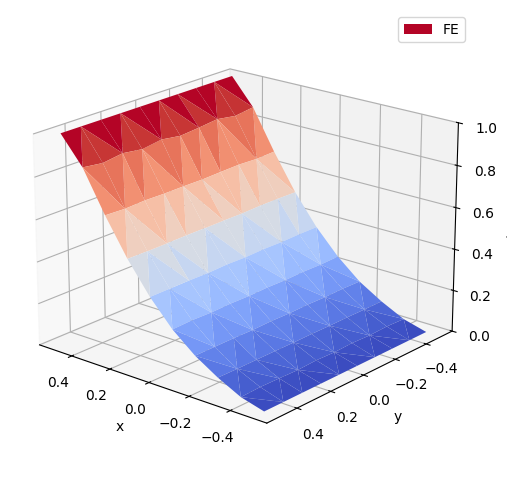

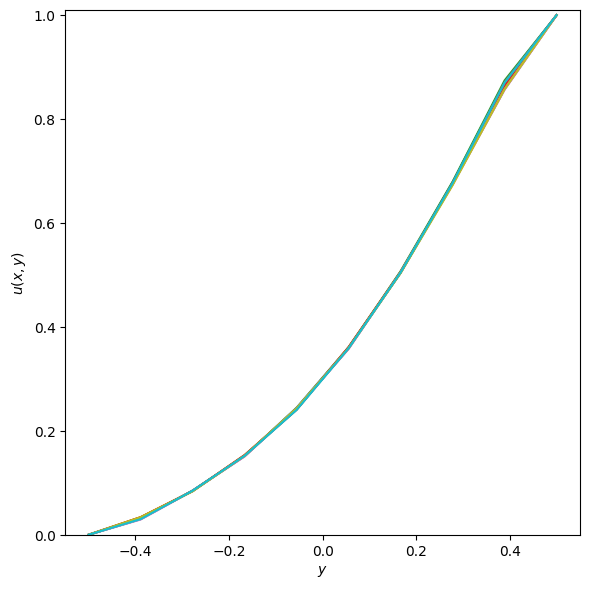

In [336]:
# Plot FE and analytical solution 

# Analytical solution
x = mesh.tri.points[:, 0]
y = mesh.tri.points[:, 1]
u_exact = x

u_exact_tmp = u_exact.reshape((n_x, n_y))
u_tmp = u.reshape((n_x, n_y))

import matplotlib as mpl
mpl.rcParams['axes3d.mouserotationstyle'] = 'arcball'  # 'azel', 'trackball', 'sphere', or 'arcball'
ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
ax.view_init(elev=20, azim=130, roll=0)
ax.plot_trisurf(mesh.tri.points[:, 0], mesh.tri.points[:, 1], u.flatten(),
    linewidth=0.2, antialiased=True, cmap=cm.coolwarm, label="FE")

ax.set_zlim([0, 1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$u(x,y)$')
ax.legend()
plt.show()

plt.rcParams['figure.figsize'] = 6, 6
plt.subplot(1, 1, 1)
plt.plot(y[:n_y], u_tmp)
plt.ylim([0, 1.01])
plt.xlabel(r'$y$')
plt.ylabel(r'$u(x,y)$')

plt.tight_layout()
plt.show()

## FEM solution gaussian pulse initial condition

In [295]:
# FEM solution gaussian pulse initial condition
from FEM_heat2d import Mesh, FEheat2D

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        if _x**2 + _y**2 < 0.1:
            return 0.0
        else:
            return 0.0

    # Domain space
    iteration_max = 10
    x_min, x_max, n_x = -0.5, 0.5, 50
    y_min, y_max, n_y = -0.5, 0.5, 50

    """ 
    Create a rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    n_points = mesh.tri.npoints
    
    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 1.0
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        # if p[0] == x_min:  # x = x_min, West
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[0] == x_max:  # x = x_max, East
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_min:  # y = y_min, South
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_max:  # y = y_max, North
        #     mesh.bc_points["dirichlet"][point_index] = 0.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == x_min and p2[0] == x_min:  # x = x_min, West
            mesh.bc_points["neumann_edge"][ch_idx] = [0.0, 0.0]
        elif p1[0] == x_max and p2[0] == x_max:  # x = x_max, East
            mesh.bc_points["neumann_edge"][ch_idx] = [0.0, 0.0]
        if p1[1] == y_min and p2[1] == y_min:  # y = y_min, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == y_max and p2[1] == y_max:  # y = y_max, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem
    """
    # Initialze
    u0 = np.zeros((n_points, 1))
    u0[:, 0] = np.exp(-(x**2 + y**2)/(2.0 * 0.15**2))
    
    heat = FEheat2D(_mesh=mesh, _f=RHS, _u=u0)
    
    heat.initialze()
    
    # Solve for u = A^-1 b
    print('iteration=')
    for i in range(iteration_max):
        heat.solve()
        print(i, end=' ', flush=True)
    
    # Get the result
    u = heat.u

The mesh has 196 boundary nodes, and 2304 internal nodes
iteration=
0 1 2 3 4 5 6 7 8 9 

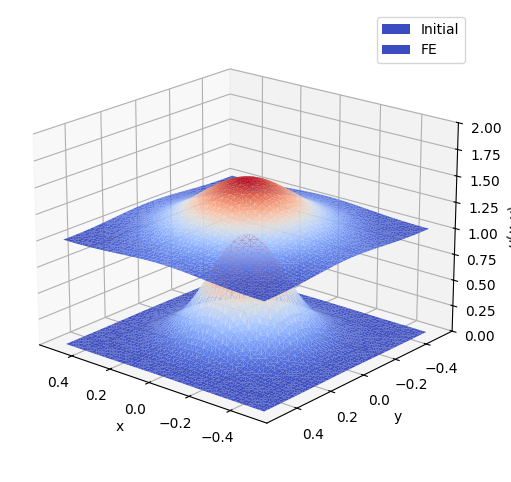

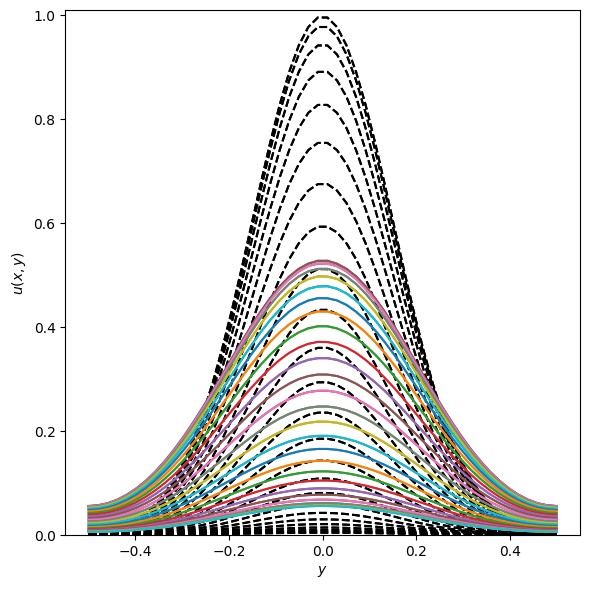

In [296]:
# Plot FE and analytical solution 
u_tmp = u.reshape((n_x, n_y))
u0_tmp = u0.reshape((n_x, n_y))

import matplotlib as mpl
mpl.rcParams['axes3d.mouserotationstyle'] = 'arcball'  # 'azel', 'trackball', 'sphere', or 'arcball'
ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
ax.view_init(elev=20, azim=130, roll=0)
ax.plot_trisurf(mesh.tri.points[:, 0], mesh.tri.points[:, 1], u0.flatten(),
    linewidth=0.2, antialiased=True, cmap=cm.coolwarm, label="Initial")

ax.plot_trisurf(mesh.tri.points[:, 0], mesh.tri.points[:, 1], u.flatten() + 1,
    linewidth=0.2, antialiased=True, cmap=cm.coolwarm, label="FE")

ax.set_zlim([0, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$u(x,y)$')
ax.legend()
plt.show()

plt.rcParams['figure.figsize'] = 6, 6
plt.subplot(1, 1, 1)
plt.plot(y[:n_y], u0_tmp, color='k', ls='--')
plt.plot(y[:n_y], u_tmp)
plt.ylim([0, 1.01])
plt.xlabel(r'$y$')
plt.ylabel(r'$u(x,y)$')
plt.tight_layout()
plt.show()

## FEM solution heat source in the middle

In [331]:
# FEM solution heat source in the middle
from FEM_heat2d import Mesh, FEheat2D

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        if _x**2 + _y**2 < 0.1:
            return 10.0
        else:
            return 0.0

    # Domain space
    iteration_max = 100
    x_min, x_max, n_x = -0.5, 0.5, 20
    y_min, y_max, n_y = -0.5, 0.5, 20

    """ 
    Create a rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    n_points = mesh.tri.npoints
    
    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 1.0
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        # if p[0] == x_min:  # x = x_min, West
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[0] == x_max:  # x = x_max, East
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_min:  # y = y_min, South
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_max:  # y = y_max, North
        #     mesh.bc_points["dirichlet"][point_index] = 0.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == x_min and p2[0] == x_min:  # x = x_min, West
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[0] == x_max and p2[0] == x_max:  # x = x_max, East
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        if p1[1] == y_min and p2[1] == y_min:  # y = y_min, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == y_max and p2[1] == y_max:  # y = y_max, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem
    """
    # Initialze
    u0 = np.zeros((n_points, 1))
    u0[:, 0] = np.exp(-(x**2 + y**2)/(2.0 * 0.15**2))
    
    heat = FEheat2D(_mesh=mesh, _f=RHS, _u=u0)
    
    heat.initialze()
    
    # Solve for u = A^-1 b
    print('iteration=')
    for i in range(iteration_max):
        heat.solve()
        print(i, end=' ', flush=True)
    
    # Get the result
    u = heat.u

The mesh has 76 boundary nodes, and 324 internal nodes
iteration=
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

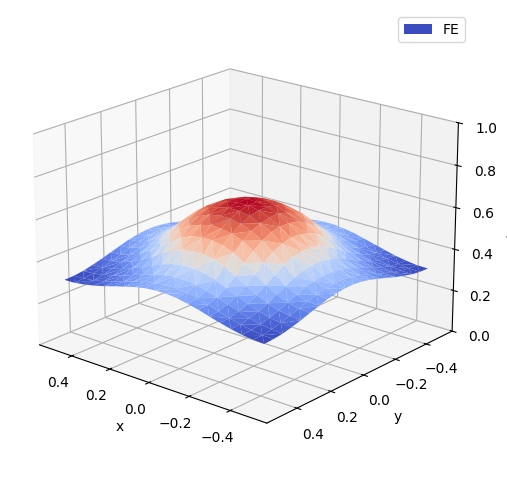

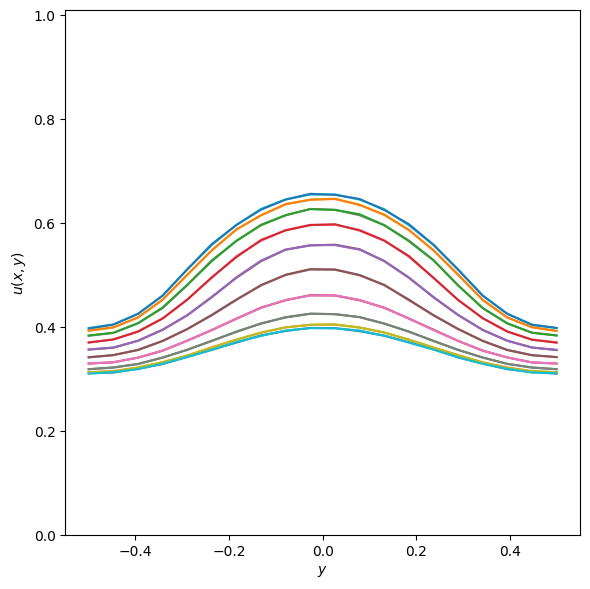

In [332]:
# Plot FE and analytical solution 
u_tmp = u.reshape((n_x, n_y))

import matplotlib as mpl
mpl.rcParams['axes3d.mouserotationstyle'] = 'arcball'  # 'azel', 'trackball', 'sphere', or 'arcball'
ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
ax.view_init(elev=20, azim=130, roll=0)
ax.plot_trisurf(mesh.tri.points[:, 0], mesh.tri.points[:, 1], u.flatten(),
    linewidth=0.2, antialiased=True, cmap=cm.coolwarm, label="FE")

ax.set_zlim([0, 1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$u(x,y)$')
ax.legend()
plt.show()

plt.rcParams['figure.figsize'] = 6, 6
plt.subplot(1, 1, 1)
plt.plot(y[:n_y], u_tmp)
plt.ylim([0, 1.01])
plt.xlabel(r'$y$')
plt.ylabel(r'$u(x,y)$')
plt.tight_layout()
plt.show()

In [334]:
fig = plty.graph_objects.Figure(data=[plty.graph_objects.Surface(z=u.flatten())])

fig.update_layout(title=dict(text='FE'), autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

## FEM solution Circular plate with heat source in the middle 

In [3]:
# FEM solution heat source in the middle (circle)
from FEM_heat2d import Mesh, FEheat2D, plot3d
mpl.rcParams['figure.figsize'] = 6, 6
plot = False
iteration_max = 10

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        if _x**2 + _y**2 < 0.1**2:
            return 10.0
        else:
            return 0.0

    """
    Domain space
    """
    x_min, x_max, n_x = -0.5, 0.5, 50
    y_min, y_max, n_y = -0.5, 0.5, 50

    """ 
    Create a mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    n_points = mesh.tri.npoints
    
    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        # if p[0] == x_min:  # x = x_min, West
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[0] == x_max:  # x = x_max, East
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_min:  # y = y_min, South
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_max:  # y = y_max, North
        #     mesh.bc_points["dirichlet"][point_index] = 0.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem
    """
    # Initialze
    u0 = np.zeros((n_points, 1))
    u0[:, 0] = np.exp(-(x**2 + y**2)/(2.0 * 0.15**2))
    
    heat = FEheat2D(_mesh=mesh, _f=RHS, _u=u0)
    
    heat.initialze()

    # Solve for u = A^-1 b
    print('iteration=')
    for i in range(iteration_max):
        heat.solve()
        print(i, end=' ', flush=True)
    
        # Get the result
        u = heat.u

        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1, projection='3d')
            plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])
            
            plt.tight_layout()
            plt.show()

The mesh has 96 boundary nodes, and 1780 internal nodes
iteration=
1 2 3 4 5 6 7 8 9 

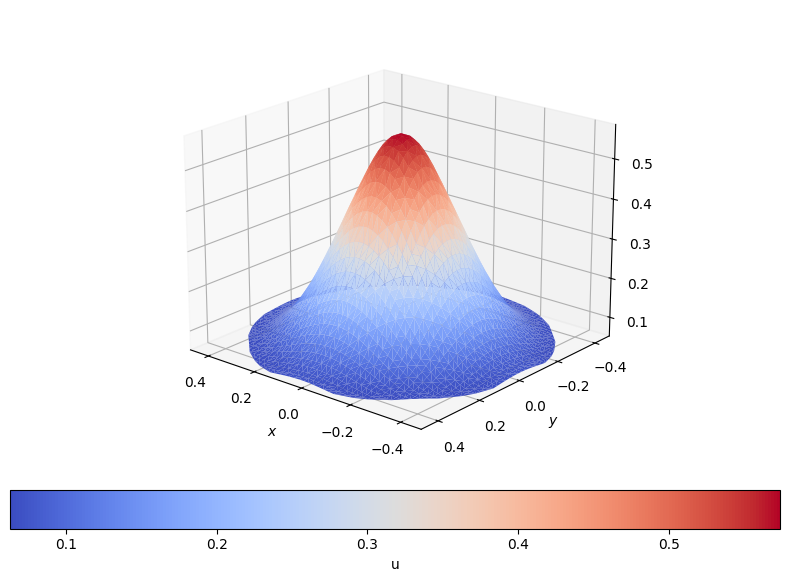

In [4]:
mpl.rcParams['figure.figsize'] = 8, 6

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])

plt.tight_layout()
# plt.savefig('u.pdf', format='pdf')
plt.show()

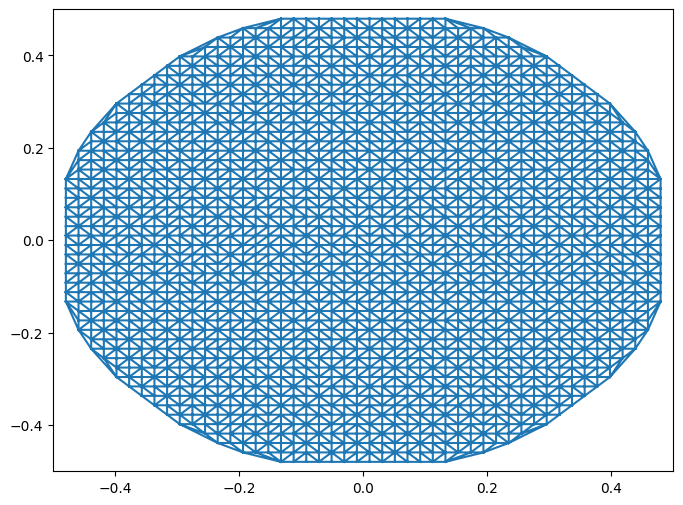

In [5]:
# plot
plt.triplot(mesh.tri.points[:,0], mesh.tri.points[:,1], mesh.tri.simplices)
# plt.plot(mesh.tri.points[:,0], mesh.tri.points[:,1], 'o')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()